This jupyter notebook is here to test properties of the training set (positive-defineteness, symmetry, etc)

In [1]:
%matplotlib inline
import torch
import torch.nn as nn
from torch.nn import functional as F
from os.path import exists
import scipy.linalg as linalg
import numpy as np
import george # <- I love this name
from scipy.optimize import minimize
import time, math, sys
import matplotlib.pyplot as plt
import matplotlib.colors as colors
plt.rcParams['figure.facecolor'] = 'white'

from CovNet import Network_Full, MatrixDataset, symmetric_log, symmetric_exp, try_gpu

In [4]:
train_log = False
train_inverse = False
#N = 52500
N = 5000
training_dir = "/home/joeadamo/Research/Data/Training-Set/"
save_dir = "/home/joeadamo/Research/CovA-NN-Emulator/Plots/"
BOSS_dir = "/home/joeadamo/Research/Data/BOSS-DR12/"
CovaPT_dir = "/home/joeadamo/Research/CovaPT/Example-Data/"

In [5]:
# data and model vectors for chi squared calculations
P_BOSS = np.loadtxt(BOSS_dir+"Cl-BOSS-DR12.dat")
P0_mean = np.loadtxt(CovaPT_dir+'P0_fit_Patchy.dat')
P2_mean = np.loadtxt(CovaPT_dir+'P2_fit_Patchy.dat')

xi_hat = np.concatenate((P_BOSS[1], P_BOSS[2]))
xi_pi = np.concatenate((P0_mean, P2_mean))
x = xi_hat - xi_pi

def chi_squared(C, x):
    P = np.linalg.inv(C)
    return np.matmul(x.T, np.matmul(P, x))

In [3]:
t1 = time.time()
data = MatrixDataset(training_dir, N, 0, train_log, train_inverse)
t2 = time.time()
print("Done loading in data, took {:0.2f} s".format(t2 - t1))

Done loading in data, took 1.98 s


In [4]:
non_positive_diag = []
non_symmetric = []
non_definete = []
t1 = time.time()
cholesky_fail = 0

min_asym = 10000; max_asym = 0; avg_asym = 0.
# first test the base matrix
for i in range(N):
    C = data[i][1].cpu().detach().numpy()
    
    # test diagonal is all positives
    for i in range(C.shape[0]):
        if C[i,i] <= 0:
            non_positive_diag.append(i)
            break
    
    # test assymetry
    C_sym = 0.5*(C + C.T)
    C_asym = 0.5*(C - C.T)
    symmetric_val = np.linalg.norm(C_asym, 2) / np.linalg.norm(C_sym, 2)
    if abs(symmetric_val) > 1e-14: # this number should be 0 if the matrix is symmetric
        non_symmetric.append(i)
        min_asym = min(symmetric_val, min_asym); max_asym = max(symmetric_val, max_asym)
        avg_asym += symmetric_val
    
    # test eigenvalues are all positive
    eigen, v = np.linalg.eig(C)
    if np.all(eigen > 0.) == False:
        non_definete.append(i)
        
    # test that cholesky decomposition works
    try:
        L = np.linalg.cholesky(C)
    except LinAlgError:
        cholesky_fail+=1
        
t2 = time.time()
print("Done! took {:0.0f} minutes {:0.2f} seconds".format(math.floor((t2 - t1)/60), (t2 - t1)%60))
print(len(non_positive_diag), "Matrices have non-positive diagonals")
print(len(non_symmetric), "({:0.2f}%) Matrices are assymetric".format(100.*len(non_symmetric)/N))
print("min / max symmetric val: [{:0.3e}, {:0.3e}] (avg = {:0.3e}".format(min_asym, max_asym, avg_asym / len(non_symmetric)))
print(len(non_definete), "Matrices don't have all positive eigenvalues")
print(cholesky_fail, "Matricec fail to do cholesky decomposition")

Done! took 1 minutes 14.74 seconds
0 Matrices have non-positive diagonals
1031 (20.62%) Matrices are assymetric
min / max symmetric val: [1.006e-14, 2.949e-13] (avg = 5.269e-14
0 Matrices don't have all positive eigenvalues
0 Matricec fail to do cholesky decomposition


In [5]:
# now test the inverse matrix

non_positive_diag_inv = []
non_symmetric_inv = []
non_definete_inv = []
min_asym = 10000; max_asym = 0; avg_asym = 0.
t1 = time.time()
for i in range(N):
    C = data[i][1].detach().numpy()
    P = np.linalg.inv(C)
    
    # test diagonal is all positives
    for i in range(C.shape[0]):
        if P[i,i] <= 0:
            non_positive_diag_inv.append(i)
            break
    
    # test assymetry
    P_sym = 0.5*(P + P.T)
    P_asym = 0.5*(P - P.T)
    symmetric_val = np.linalg.norm(P_asym, 2) / np.linalg.norm(P_sym, 2)
    if abs(symmetric_val) > 1e-14: # this number should be 0 if the matrix is symmetric
        non_symmetric_inv.append(i)
        min_asym = min(symmetric_val, min_asym); max_asym = max(symmetric_val, max_asym)
        avg_asym += symmetric_val
    
    # test eigenvalues are all positive
    eigen, v = np.linalg.eig(P)
    if np.all(eigen > 0.) == False:
        non_definete_inv.append(i)
        
t2 = time.time()
print("Done! took {:0.0f} minutes {:0.2f} seconds".format(math.floor((t2 - t1)/60), (t2 - t1)%60))
print(len(non_positive_diag_inv), "Matrices have non-positive diagonals")
print(len(non_symmetric_inv), "({:0.2f}%) Matrices are assymetric".format(100.*len(non_symmetric_inv)/N))
print("min / max symmetric val: [{:0.3e}, {:0.3e}] (avg = {:0.3e}".format(min_asym, max_asym, avg_asym / len(non_symmetric)))
print(len(non_definete_inv), "Matrices don't have all positive eigenvalues")

KeyboardInterrupt: 

0


<Figure size 432x288 with 0 Axes>

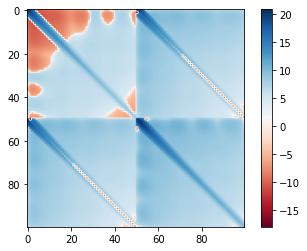

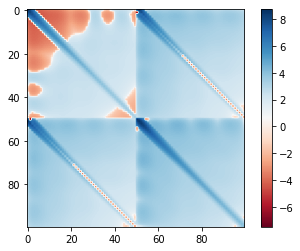

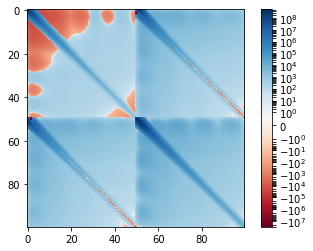

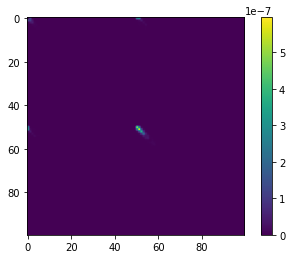

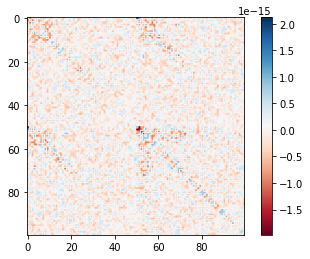

In [31]:
# test the logarithm function and make sure exp(log(C)) = C
idx = np.random.randint(0, N)
C = data[idx][1]
C_log = symmetric_log(C); C_1 = symmetric_exp(C_log)
# C and C_1 should be equal, so C - C_1 should just be a matrix of all zeros
idx_bad = np.where(abs((C - C_1) / C) > 1e-14)
print(len(idx_bad[0]))
# plt.imshow(C - C_1, cmap="RdBu")
# cbar = plt.colorbar()

plt.figure()
C_sinh = np.arcsinh(C)
C_2 = np.sinh(C_sinh)
plt.figure()
plt.imshow(C_sinh, cmap="RdBu")
cbar = plt.colorbar()

plt.figure()
plt.imshow(C_log, cmap="RdBu")
cbar = plt.colorbar()

plt.figure()
m = plt.imshow(C_1, cmap="RdBu", norm=colors.SymLogNorm(linthresh=1.))
cbar = plt.colorbar()

plt.figure()
plt.imshow(abs(C_1 - C))
cbar = plt.colorbar()

plt.figure()
plt.imshow((C_1 - C) / C, cmap="RdBu")
cbar = plt.colorbar()

In [8]:
from CovNet import symmetric_log, symmetric_exp, try_gpu
x = torch.linspace(-100, 100, 25, device=try_gpu())
x_log = symmetric_log(x)
x_1 = symmetric_exp(x_log)
print(x)
print(x_log)
print(x_1)
print(x_1 - x)

tensor([-1.0000e+02, -9.1667e+01, -8.3333e+01, -7.5000e+01, -6.6667e+01,
        -5.8333e+01, -5.0000e+01, -4.1667e+01, -3.3333e+01, -2.5000e+01,
        -1.6667e+01, -8.3333e+00,  3.8147e-06,  8.3333e+00,  1.6667e+01,
         2.5000e+01,  3.3333e+01,  4.1667e+01,  5.0000e+01,  5.8333e+01,
         6.6667e+01,  7.5000e+01,  8.3333e+01,  9.1667e+01,  1.0000e+02],
       device='cuda:0')
tensor([-2.0043e+00, -1.9669e+00, -1.9260e+00, -1.8808e+00, -1.8304e+00,
        -1.7733e+00, -1.7076e+00, -1.6301e+00, -1.5357e+00, -1.4150e+00,
        -1.2472e+00, -9.7004e-01,  1.6567e-06,  9.7004e-01,  1.2472e+00,
         1.4150e+00,  1.5357e+00,  1.6301e+00,  1.7076e+00,  1.7733e+00,
         1.8304e+00,  1.8808e+00,  1.9260e+00,  1.9669e+00,  2.0043e+00],
       device='cuda:0')
tensor([-1.0000e+02, -9.1667e+01, -8.3333e+01, -7.5000e+01, -6.6667e+01,
        -5.8333e+01, -5.0000e+01, -4.1667e+01, -3.3333e+01, -2.5000e+01,
        -1.6667e+01, -8.3333e+00,  3.8147e-06,  8.3333e+00,  1.6667e+01,
 

In [28]:
# Convert data in .txt format to .npz format
# training_dir = "/home/joeadamo/Research/Data/Training-Set/"
# new_dir = "/home/joeadamo/Research/Data/Training-Set-New/"
# for idx in range(52500):
    
#     file = training_dir+"CovA-"+f'{idx:05d}'+".txt"
#     f = open(file)
#     header = f.readline()
#     header = f.readline()
#     f.close()
#     header = torch.from_numpy(np.fromstring(header[2:-1], sep=","))
#     params = torch.cat([header[0:4], header[5:]]).detach().numpy()
#     # load in matrix
#     C = np.loadtxt(file, skiprows=2)
#     np.savez(new_dir+"CovA-"+f'{idx:05d}'+".npz", params=params, C=C)
    
#     test = np.load(new_dir+"CovA-"+f'{idx:05d}'+".npz")
#     params_l = test["params"]; C_l = test["C"]
#     assert np.array_equal(params_l, params) and np.array_equal(C, C_l)
# print("Done!")

Done!


2592371.3494188264 1219.9668869786315


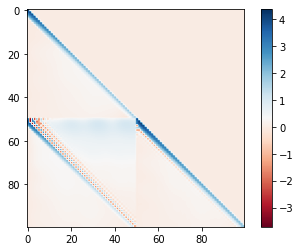

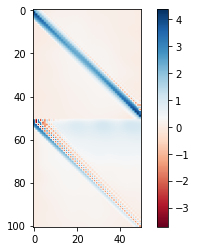

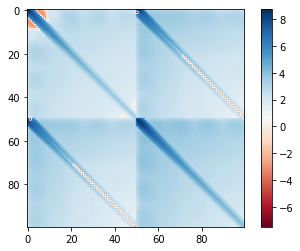

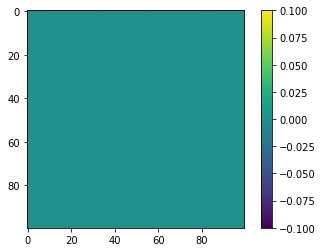

In [6]:
# Test Cholesky decomposition
train_cholesky = True
idx = np.random.randint(0, N)
C = data[idx][1].view(1,100,100)
#C = symmetric_log(C)

if train_cholesky:
    C = torch.linalg.cholesky(C)
B = C.shape[0]
L1 = torch.tril(C)[:,:,:50]; L2 = torch.tril(C)[:,:,50:]
L1 = torch.cat((torch.zeros((B,1, 50), device=try_gpu()), L1), 1)
L2 = torch.cat((torch.flip(L2, [1,2]), torch.zeros((B,1, 50), device=try_gpu())),1)
C_half = L1 + L2

C_full = torch.zeros((B, 100,100), device=try_gpu())
C_full[:,:,:50] = C_full[:,:,:50] + C_half[:,1:,:]
C_full[:,:,50:] = C_full[:,:,50:] + torch.flip(C_half[:,:-1,:], [1,2])
L = torch.tril(C_full); U = torch.transpose(torch.tril(C_full, diagonal=-1),1,2)
if train_cholesky: # <- undo the cholesky decomposition
    C_full = torch.matmul(L, torch.transpose(L, 1, 2))
else:
    C_full = L + U
    
L = L.view(100,100); C = C.view(100,100); C_half = C_half.view(101,50); C_full = C_full.view(100,100)
chisq_true = chi_squared(C.cpu().detach().numpy(), x)
chisq_pred = chi_squared(C_full.cpu().detach().numpy(), x)
print(chisq_true, chisq_pred)

plt.imshow((symmetric_log(C).cpu()), cmap="RdBu")
cbar = plt.colorbar()

plt.figure()
plt.imshow((symmetric_log(C_half).cpu()), cmap="RdBu")
cbar = plt.colorbar()

plt.figure()
plt.imshow((symmetric_log(C_full).cpu()), cmap="RdBu")
cbar = plt.colorbar()
# try training the quadrants independently

plt.figure()
plt.imshow(abs(torch.matmul(C, torch.t(C)) - C_full).cpu())
cbar = plt.colorbar()

idx =  3481


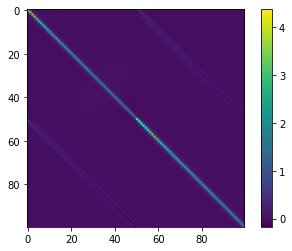

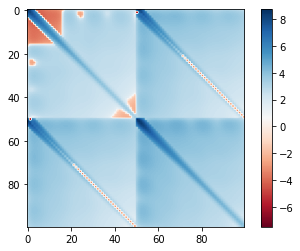

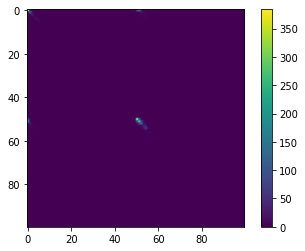

In [129]:
# test code to convert to / from correlation matrix
idx = np.random.randint(0, N)
print("idx = ", idx)
C = data[idx][1].view(1, 100, 100)
D = torch.sqrt(torch.diagonal(C,0,1,2))
D = torch.diag_embed(D)
Corr = torch.matmul(torch.linalg.inv(D), torch.matmul(C, torch.linalg.inv(D)))
Corr = Corr + (symmetric_log(D) - torch.eye(100))

plt.figure()
plt.imshow(Corr.view(100,100).cpu())
cbar = plt.colorbar()

D_1 = torch.diag_embed(torch.diagonal(Corr,0,1,2))
Corr = Corr - (D_1) + torch.eye(100)
D_1 = symmetric_exp(D_1)
C_1 = torch.matmul(D_1, torch.matmul(Corr, D_1))

plt.figure()
plt.imshow(symmetric_log(C_1).view(100,100).cpu(), cmap="RdBu")
cbar = plt.colorbar()

plt.figure()
plt.imshow(abs(C_1 - C).view(100,100).cpu())
cbar = plt.colorbar()

In [66]:
# Test PCA decomposition
PCA_dir = "/home/joeadamo/Research/CovA-NN-Emulator/PCA-Set/"
N_PCA = 50
num_components = 20
C_PCA = np.zeros((N_PCA, 100, 100))
params_PCA = np.zeros((N_PCA, 6))
l = np.zeros((N_PCA, int(100*99/2)))
d = np.zeros((N_PCA, 100))

for i in range(N_PCA):
    
    # STEP 1: load in data
    temp = np.load(PCA_dir+"CovA-"+f'{i:04d}'+".npz")
    params_PCA[i] = np.delete(temp["params"], 4)
    C_PCA[i] = temp["C"]

    # STEP 2: do LDLT decomposition and extract l, d vectors
    L, D, P = linalg.ldl(C_PCA[i])
    d[i] = np.log(np.diag(D))
    l[i] = C_PCA[i][ np.tril_indices(100,-1)]

# STEP 2.5: get aexample parameter + matrix set to do testing on
temp = np.load(PCA_dir+"CovA-"+f'{N_PCA+1:04d}'+".npz")
params_test =  np.delete(temp["params"], 4).reshape(1,6)
C_test = temp["C"]
    
# STEP 3: find the element-wise mean and variance and remove them from d, l
d_mean = np.mean(d, axis=0)
d_var  = np.var(d, axis=0)
l_mean = np.mean(l, axis=0)
l_var  = np.var(l, axis=0)

d = (d - d_mean) / np.sqrt(d_var)
l = (l - l_mean) / np.sqrt(l_var)

# STEP 4: do a singular-value decomposition for l and d (treating both as matrices)
U_d, S_d, V_d = np.linalg.svd(d, full_matrices=False); S_d = np.diag(S_d); V_d = V_d.T
U_l, S_l, V_l = np.linalg.svd(l, full_matrices=False); S_l = np.diag(S_l); V_l = V_l.T

# STEP 5: find the principle components and weights!
# Columns of phi = PCs, Rows of W = weights
phi_d = np.matmul(U_d, S_d) / np.sqrt(N_PCA)
phi_l = np.matmul(U_l, S_l) / np.sqrt(N_PCA)
W_d = np.sqrt(N_PCA) * V_d
W_l = np.sqrt(N_PCA) * V_l

print(phi_d.shape, W_d.shape)
print(phi_l.shape, W_l.shape)

(1, 6)
(50, 50) (100, 50)
(50, 50) (4950, 50)


In [96]:
# do a gaussian process interpolation on the principle components
def neg_ln_like(p, y):
    gp.set_parameter_vector(p)
    return -gp.log_likelihood(y)

def grad_neg_ln_like(p, y):
    gp.set_parameter_vector(p)
    return -gp.grad_log_likelihood(y)

Theta_bounds = np.array([[66.5, 75.5],[0.2699, 0.3459],[0.1157, 0.1535],[8.586e-10, 2.031e-9],[1.806, 2.04], [-2.962, 0.458]])
Theta = (params_PCA - Theta_bounds[:,0]) / (Theta_bounds[:,1] - Theta_bounds[:,0])
Theta_test = (params_test - Theta_bounds[:,0]) / (Theta_bounds[:,1] - Theta_bounds[:,0])

W_d_new = np.zeros(num_components)
W_l_new = np.zeros(num_components)

# we do a seperate gaussian process for each PC
for pc in range(1):#num_components):
    
    w_d = W_d[pc]; w_l = W_l[pc]
    
    kernel = george.kernels.ExpSquaredKernel(0.5, ndim=6)
    gp1 = george.GP(kernel)
    gp2 = george.GP(kernel)
    
    w_d_err = w_d - np.mean(w_d)
    w_l_err = w_l - np.mean(w_l)
    gp1.compute(Theta)#, w_d_err)
    gp2.compute(Theta)#, w_l_err)
    #temp1 = gp1.predict(w_d, Theta_test, return_var=False)
    #temp2 = gp2.predict(w_l, params_test, return_var=False)
    print("Initial ln-likelihood: {0:.2f}".format(gp1.log_likelihood(w_d)))
    result1 = minimize(neg_ln_like, gp1.get_parameter_vector(), args=(w_d), jac=grad_neg_ln_like)
    result2 = minimize(neg_ln_like, gp2.get_parameter_vector(), args=(w_l), jac=grad_neg_ln_like)
    #print(result)
    gp1.set_parameter_vector(result.x)
    gp2.set_parameter_vector(result.x)
    print("Final ln-likelihood: {0:.2f}".format(gp1.log_likelihood(w_d)))
    W_d_new[pc], var1 = gp1.predict(w_d, Theta_test, return_var=True)
    W_l_new[pc], var2 = gp2.predict(w_l, Theta_test, return_var=True)
    print(np.amin(w_d), np.amax(w_d))
    print(W_d_new[pc], W_l_new[pc])
    

Initial ln-likelihood: -1057.85
Final ln-likelihood: -70.72
-2.566378854423862 1.9982932416640775
2.657696828838898e-23 5.379015306509834e-23
